### Netflix Prize Dataset EDA

In this notebook, we will primarily be performing some exploratory data analysis on the Netflix Prize dataset.

Our initial questions that we want to explore with this data set:
1. What are the most rated movies
2. What are the most POORLY rated movies? What are the most Well rated movies?
3. Who are these “top 10k” users?

In [18]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


DATA_PATH = "../data"
NETFLIX_FOLDER_PATH = os.path.join(DATA_PATH, "netflix_prize")
USER_FOLDER_PATH = os.path.join(NETFLIX_FOLDER_PATH, "training_set")
MAPPING_PATH = os.path.join(DATA_PATH,"netflix_to_imdb.json")

## What are the most rated movies?
- We must first plot the distribution in order to see this 

In [19]:
def load_netflix_to_imdb_mapping(mapping_path):
    """Load the Netflix to IMDB mapping file"""
    with open(mapping_path, 'r') as f:
        netflix_to_imdb = json.load(f)
    return set(netflix_to_imdb.keys())  # Convert movie IDs to set for faster lookup

### process_rating_file()
- Process the various netflix files and count the ratingers per user

In [20]:
def process_rating_file(filepath, valid_movie_ids):
    """Process a single rating file and count ratings per user, filtering for valid movies only"""
    user_ratings = defaultdict(int)
    current_movie = None
    
    with open(filepath, 'r') as f:
        for line in f:
            if line.endswith(':\n'):  # Movie ID line
                current_movie = line.strip(':\n')
            elif line.strip() and current_movie in valid_movie_ids:  # Rating line for valid movie
                movie_data = line.strip().split(',')
                if len(movie_data) >= 1:
                    user_id = movie_data[0]
                    user_ratings[user_id] += 1
    
    return user_ratings

In [21]:
def analyze_user_distribution(netflix_folder_path, mapping_path):
    """Analyze and plot the distribution of movie ratings per user"""
    print("Loading Netflix to IMDB mapping...")
    valid_movie_ids = load_netflix_to_imdb_mapping(mapping_path)
    print(f"Found {len(valid_movie_ids)} valid movies in mapping")
    
    print("Processing rating files...")
    all_user_ratings = defaultdict(int)
    
    # Process each rating file
    training_set_path = os.path.join(netflix_folder_path, "training_set")
    for filename in tqdm(sorted(os.listdir(training_set_path))):
        if filename.startswith('mv_'):
            filepath = os.path.join(training_set_path, filename)
            file_user_ratings = process_rating_file(filepath, valid_movie_ids)
            
            # Merge ratings
            for user, count in file_user_ratings.items():
                all_user_ratings[user] += count
    
    # Convert to list for plotting
    rating_counts = list(all_user_ratings.values())
    
    # Calculate statistics
    stats = {
        'Total Users': len(rating_counts),
        'Mean Ratings': np.mean(rating_counts),
        'Median Ratings': np.median(rating_counts),
        'Max Ratings': max(rating_counts),
        'Min Ratings': min(rating_counts)
    }
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Distribution with log scale
    plt.subplot(2, 1, 1)
    plt.hist(rating_counts, bins=100, log=True, color='skyblue', edgecolor='black')
    plt.title('Distribution of Movie Ratings per User (Log Scale)', pad=20)
    plt.xlabel('Number of Movie Ratings')
    plt.ylabel('Number of Users (Log Scale)')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Simple box plot
    plt.subplot(2, 1, 2)
    plt.boxplot(rating_counts, vert=False)
    plt.title('Box Plot of Movie Ratings per User', pad=20)
    plt.xlabel('Number of Movie Ratings')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Percentile distribution
    percentiles = [25, 50, 75, 90, 95, 99]
    percentile_values = np.percentile(rating_counts, percentiles)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(percentiles)), percentile_values, color='skyblue', edgecolor='black')
    plt.xticks(range(len(percentiles)), [f'{p}th' for p in percentiles])
    plt.title('Movie Rating Counts at Different Percentiles')
    plt.xlabel('Percentile')
    plt.ylabel('Number of Movie Ratings')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return stats, rating_counts

Loading Netflix to IMDB mapping...
Found 9445 valid movies in mapping
Processing rating files...


100%|██████████| 17770/17770 [01:18<00:00, 226.92it/s]


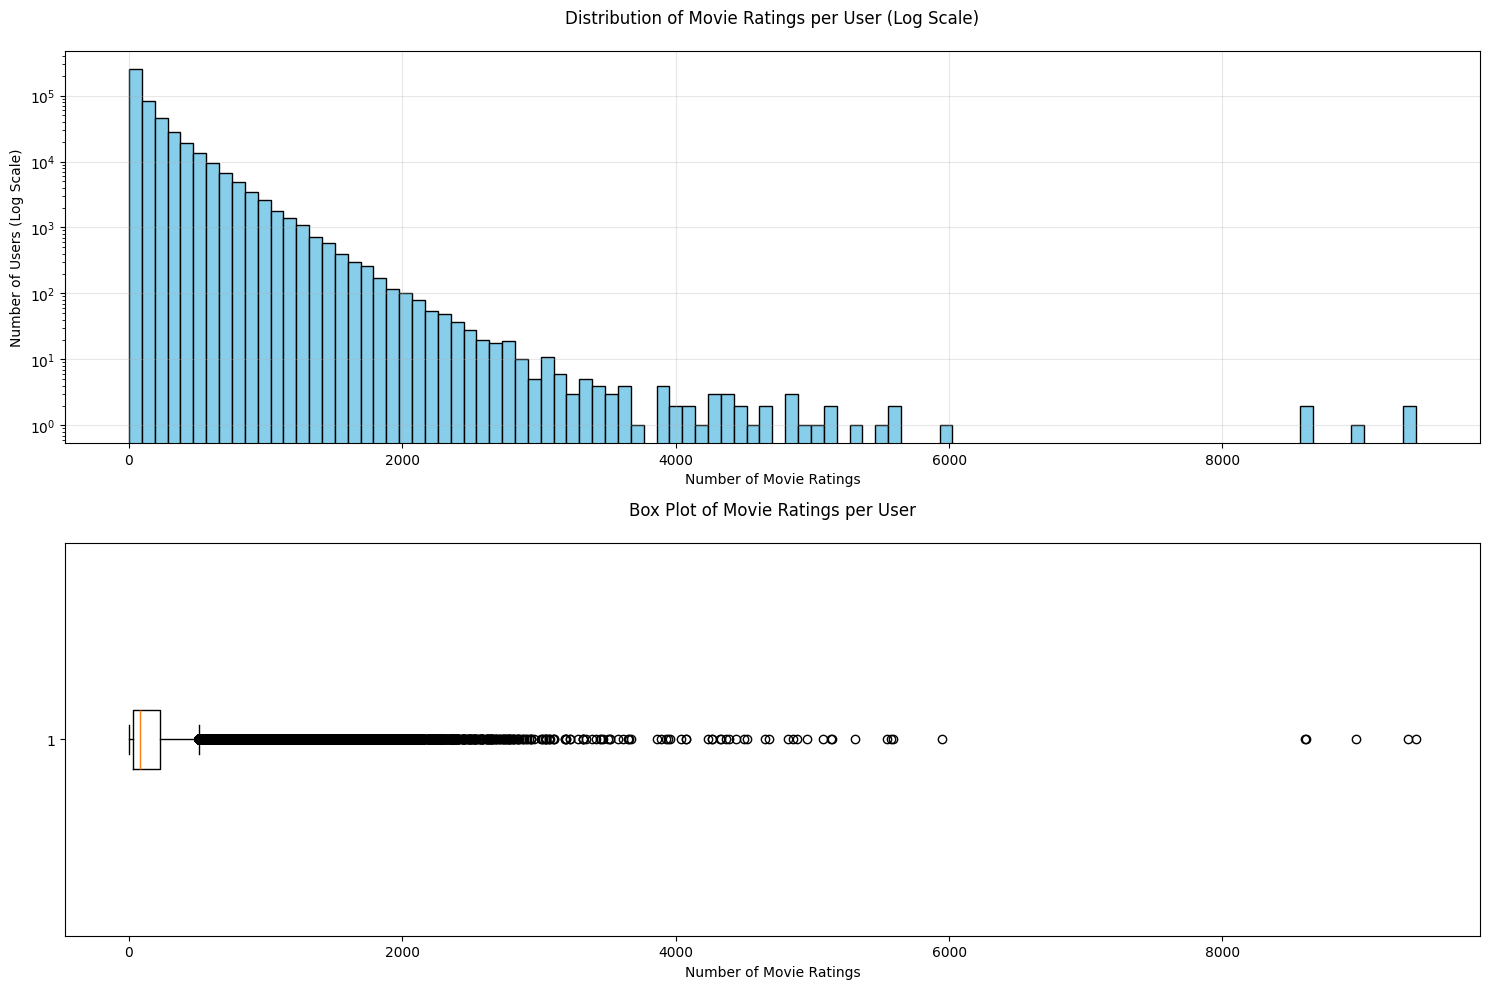

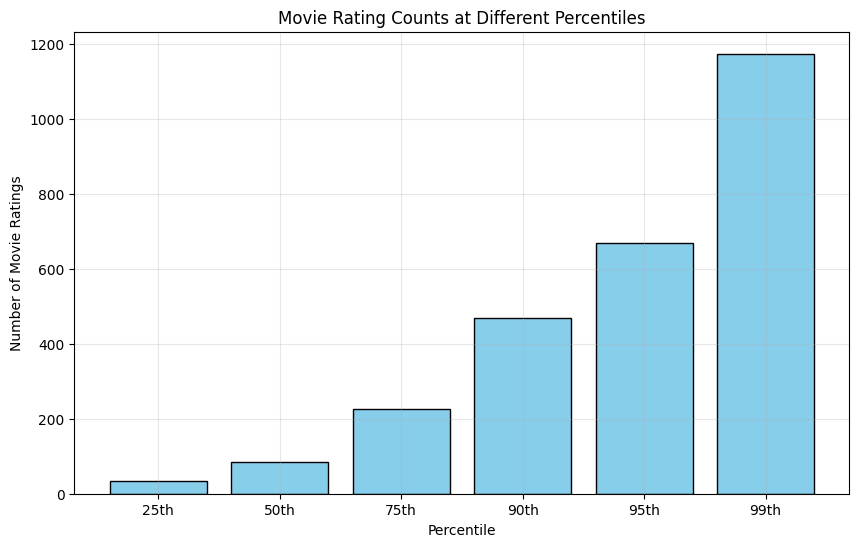


Movie Rating Distribution Statistics:
Total Users: 479,456.00
Mean Ratings: 180.09
Median Ratings: 84.00
Max Ratings: 9,413.00
Min Ratings: 1.00

Percentile Analysis:
25th percentile: 34.00 ratings
50th percentile: 84.00 ratings
75th percentile: 225.00 ratings
90th percentile: 469.00 ratings
95th percentile: 670.00 ratings
99th percentile: 1,175.00 ratings


In [22]:

stats, rating_counts = analyze_user_distribution(NETFLIX_FOLDER_PATH, MAPPING_PATH)

print("\nMovie Rating Distribution Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:,.2f}")

# Calculate and print percentiles
percentiles = [25, 50, 75, 90, 95, 99]
print("\nPercentile Analysis:")
for p in percentiles:
    value = np.percentile(rating_counts, p)
    print(f"{p}th percentile: {value:,.2f} ratings")